In [ ]:
# Apply SMOTE only on the training dataimport os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from collections import Counter
from imblearn.over_sampling import SMOTE
import logging
import os
# Configure logging
logging.basicConfig(filename='model_predictions.log', level=logging.INFO,
                    format='%(asctime)s %(levelname)s:%(message)s')

def load_features_and_labels(base_folder):
    """
    Load features and corresponding labels from the dataset.
    Combines REAL and BALANCED_REAL to handle class imbalance.
    """
    X = []
    y = []
    label_map = {"FAKE": 0, "REAL": 1, "BALANCED_REAL": 1}  # Map class labels to integers

    for category_folder in os.listdir(base_folder):
        category_path = os.path.join(base_folder, category_folder)
        if not os.path.isdir(category_path):
            continue

        label = label_map.get(category_folder)
        if label is None:
            continue

        print(f"Processing folder: {category_folder} (Label: {label})")

        for video_folder in os.listdir(category_path):
            video_folder_path = os.path.join(category_path, video_folder)
            if not os.path.isdir(video_folder_path):
                continue

            features_path = os.path.join(video_folder_path, "features.npy")
            if os.path.exists(features_path):
                try:
                    features = np.load(features_path)
                    if features.ndim == 1:  # Ensure features are 2D
                        features = features.reshape(1, -1)
                    X.append(features.flatten())  # Flatten feature array
                    y.append(label)
                except Exception as e:
                    print(f"Error loading features from {features_path}: {e}")
            else:
                print(f"Features file not found: {features_path}")

    print(f"Loaded {len(X)} feature sets.")
    print("Initial Class Distribution:", Counter(y))
    return np.array(X), np.array(y)

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluate the model and print detailed metrics.
    """
    y_pred = model.predict(X_test)
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["FAKE", "REAL"]))
    print(f"{model_name} Accuracy:", accuracy_score(y_test, y_pred))
    print(f"{model_name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

def train_svm(X_train, y_train):
    """
    Train an SVM classifier with hyperparameter tuning.
    """
    # Hyperparameter tuning with stratified cross-validation
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced', None]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Best model
    svm_model = grid_search.best_estimator_
    print("Best Parameters for SVM:", grid_search.best_params_)

    # Save the model
    joblib.dump(svm_model, "svm_model_optimized.pkl")
    print("SVM model saved as 'svm_model_optimized.pkl'")
    return svm_model

def train_knn(X_train, y_train):
    """
    Train a KNN classifier with hyperparameter tuning.
    """
    # Hyperparameter tuning with stratified cross-validation
    param_grid = {
        'n_neighbors': [3, 5, 7],
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance']
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Best model
    knn_model = grid_search.best_estimator_
    print("Best Parameters for KNN:", grid_search.best_params_)

    # Save the model
    joblib.dump(knn_model, "knn_model_optimized.pkl")
    print("KNN model saved as 'knn_model_optimized.pkl'")
    return knn_model

def predict_new_data(new_features, scaler, pca, model_path, threshold=0.5):
    """
    Predict the class of new data with logging and threshold adjustment.
    """
    try:
        if new_features.ndim == 1:
            new_features = new_features.reshape(1, -1)

        # Apply scaling and PCA
        new_features_scaled = scaler.transform(new_features)
        new_features_pca = pca.transform(new_features_scaled)

        # Load the trained model
        model = joblib.load(model_path)

        # Get probability estimates
        probs = model.predict_proba(new_features_pca)

        # Apply threshold
        prediction = (probs[:, 1] >= threshold).astype(int)

        # Map prediction to class label
        label_map = {0: "FAKE", 1: "REAL"}
        predicted_label = label_map.get(prediction[0], "Unknown")

        # Log the prediction
        logging.info(f"Predicted: {predicted_label}, Probabilities: {probs[0]}")

        return predicted_label
    except Exception as e:
        logging.error(f"Error during prediction: {e}")
        return "Error"

# Main Execution Flow
if __name__ == "__main__":
    # Debugging: Check folder structure and features
    print("Checking dataset structure...")
    base_folder = "output_frames_balanced"
    if not os.path.exists(base_folder):
        print(f"Base folder not found: {base_folder}")
        exit()

    # Load features and labels
    X, y = load_features_and_labels(base_folder)

    if len(X) == 0:
        print("Error: No data loaded. Ensure the dataset is properly organized and 'features.npy' files exist.")
    else:
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Save the scaler for consistent feature preprocessing during deployment
        joblib.dump(scaler, "scaler.pkl")
        print("Feature scaler saved as 'scaler.pkl'")

        # Apply PCA for dimensionality reduction (optional)
        pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
        X_pca = pca.fit_transform(X_scaled)
        print(f"Reduced feature dimensions from {X_scaled.shape[1]} to {X_pca.shape[1]}")
        joblib.dump(pca, "pca_transformer.pkl")
        print("PCA transformer saved as 'pca_transformer.pkl'")

        # Split dataset into train and test sets with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X_pca, y, test_size=0.2, random_state=42, stratify=y)

        print("Before SMOTE, training class distribution:", Counter(y_train))

        # Apply SMOTE to handle class imbalance
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        print("After SMOTE, training class distribution:", Counter(y_train_resampled))

        # Save the resampled training data (optional)
        # joblib.dump((X_train_resampled, y_train_resampled), "train_resampled.pkl")

        # Train and evaluate SVM
        svm_model = train_svm(X_train_resampled, y_train_resampled)
        evaluate_model(svm_model, X_test, y_test, model_name="SVM")

        # Train and evaluate KNN
        knn_model = train_knn(X_train_resampled, y_train_resampled)
        evaluate_model(knn_model, X_test, y_test, model_name="KNN")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE, training class distribution:", Counter(y_train_resampled))


Checking dataset structure...
Processing folder: BALANCED_REAL (Label: 1)
Processing folder: REAL (Label: 1)
Processing folder: FAKE (Label: 0)
Loaded 646 feature sets.
Initial Class Distribution: Counter({1: 323, 0: 323})
Feature scaler saved as 'scaler.pkl'
Reduced feature dimensions from 512 to 111
PCA transformer saved as 'pca_transformer.pkl'
Before SMOTE, training class distribution: Counter({0: 258, 1: 258})
After SMOTE, training class distribution: Counter({0: 258, 1: 258})
Best Parameters for SVM: {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
SVM model saved as 'svm_model_optimized.pkl'
SVM Classification Report:
              precision    recall  f1-score   support

        FAKE       0.97      0.92      0.94        65
        REAL       0.93      0.97      0.95        65

    accuracy                           0.95       130
   macro avg       0.95      0.95      0.95       130
weighted avg       0.95      0.95      0.95       130

SVM Accuracy: 0.9461538461538461
S

In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from collections import Counter
from imblearn.over_sampling import SMOTE
import logging

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(message)s'
)

def load_features_and_labels(base_folder):
    """
    Load features and corresponding labels from the dataset.
    Combines REAL and BALANCED_REAL to handle class imbalance.
    """
    X = []
    y = []
    label_map = {"FAKE": 0, "REAL": 1, "BALANCED_REAL": 1}  # Map class labels to integers

    for category_folder in os.listdir(base_folder):
        category_path = os.path.join(base_folder, category_folder)
        if not os.path.isdir(category_path):
            continue

        label = label_map.get(category_folder)
        if label is None:
            continue

        logging.info(f"Processing folder: {category_folder} (Label: {label})")

        for video_folder in os.listdir(category_path):
            video_folder_path = os.path.join(category_path, video_folder)
            if not os.path.isdir(video_folder_path):
                continue

            features_path = os.path.join(video_folder_path, "features.npy")
            if os.path.exists(features_path):
                try:
                    features = np.load(features_path)
                    if features.ndim == 1:  # Ensure features are 2D
                        features = features.reshape(1, -1)
                    X.append(features.flatten())  # Flatten feature array
                    y.append(label)
                except Exception as e:
                    logging.error(f"Error loading features from {features_path}: {e}")
            else:
                logging.warning(f"Features file not found: {features_path}")

    logging.info(f"Loaded {len(X)} feature sets.")
    logging.info("Initial Class Distribution: " + str(Counter(y)))
    return np.array(X), np.array(y)

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluate the model and print detailed metrics.
    """
    y_pred = model.predict(X_test)
    logging.info(f"{model_name} Classification Report:\n{classification_report(y_test, y_pred, target_names=['FAKE', 'REAL'])}")
    logging.info(f"{model_name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    logging.info(f"{model_name} Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"{model_name} Evaluation Completed. Check 'model_training.log' for details.")

def train_svm(X_train, y_train):
    """
    Train an SVM classifier with hyperparameter tuning.
    """
    logging.info("Starting SVM training with hyperparameter tuning.")

    # Hyperparameter tuning with stratified cross-validation
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced', None]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model
    svm_model = grid_search.best_estimator_
    logging.info(f"Best Parameters for SVM: {grid_search.best_params_}")

    # Save the model
    joblib.dump(svm_model, "svm_model_optimized.pkl")
    logging.info("SVM model saved as 'svm_model_optimized.pkl'")
    return svm_model

def train_knn(X_train, y_train):
    """
    Train a KNN classifier with hyperparameter tuning.
    """
    logging.info("Starting KNN training with hyperparameter tuning.")

    # Hyperparameter tuning with stratified cross-validation
    param_grid = {
        'n_neighbors': [3, 5, 7],
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance']
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model
    knn_model = grid_search.best_estimator_
    logging.info(f"Best Parameters for KNN: {grid_search.best_params_}")

    # Save the model
    joblib.dump(knn_model, "knn_model_optimized.pkl")
    logging.info("KNN model saved as 'knn_model_optimized.pkl'")
    return knn_model

def main():
    # Debugging: Check folder structure and features
    logging.info("Starting the training pipeline.")
    base_folder = "output_frames_balanced"
    if not os.path.exists(base_folder):
        logging.critical(f"Base folder not found: {base_folder}. Exiting training.")
        print(f"Base folder not found: {base_folder}")
        exit()

    # Load features and labels
    X, y = load_features_and_labels(base_folder)

    if len(X) == 0:
        logging.critical("No data loaded. Ensure the dataset is properly organized and 'features.npy' files exist. Exiting training.")
        print("Error: No data loaded. Ensure the dataset is properly organized and 'features.npy' files exist.")
        exit()
    else:
        # Split dataset into train and test sets with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)
        logging.info("Dataset split into training and testing sets.")
        logging.info(f"Training set size: {X_train.shape[0]}, Testing set size: {X_test.shape[0]}")
        logging.info(f"Training Class Distribution: {Counter(y_train)}")
        logging.info(f"Testing Class Distribution: {Counter(y_test)}")

        # Scale features: Fit on training data, transform both training and testing data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        logging.info("Feature scaling applied using StandardScaler.")

        # Save the scaler for consistent feature preprocessing during deployment
        joblib.dump(scaler, "scaler.pkl")
        logging.info("Feature scaler saved as 'scaler.pkl'.")

        # Apply PCA: Fit on training data, transform both training and testing data
        pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        logging.info(f"PCA applied. Reduced feature dimensions from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]}.")

        # Save the PCA transformer
        joblib.dump(pca, "pca_transformer.pkl")
        logging.info("PCA transformer saved as 'pca_transformer.pkl'.")

        # Apply SMOTE to handle class imbalance only on the training data
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)
        logging.info(f"After SMOTE, training class distribution: {Counter(y_train_resampled)}.")

        # Optionally, save the resampled training data
        # joblib.dump((X_train_resampled, y_train_resampled), "train_resampled.pkl")

        # Train and evaluate SVM
        svm_model = train_svm(X_train_resampled, y_train_resampled)
        evaluate_model(svm_model, X_test_pca, y_test, model_name="SVM")

        # Train and evaluate KNN
        knn_model = train_knn(X_train_resampled, y_train_resampled)
        evaluate_model(knn_model, X_test_pca, y_test, model_name="KNN")

        logging.info("Training pipeline completed successfully.")

if __name__ == "__main__":
    main()


SVM Evaluation Completed. Check 'model_training.log' for details.
KNN Evaluation Completed. Check 'model_training.log' for details.


In [6]:
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from collections import Counter
from imblearn.over_sampling import SMOTE
import logging

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(message)s'
)

def load_features_and_labels(base_folder):
    """
    Load features and corresponding labels from the dataset.
    Combines REAL and BALANCED_REAL to handle class imbalance.
    """
    X = []
    y = []
    label_map = {"FAKE": 0, "REAL": 1, "BALANCED_REAL": 1}  # Map class labels to integers

    for category_folder in os.listdir(base_folder):
        category_path = os.path.join(base_folder, category_folder)
        if not os.path.isdir(category_path):
            continue

        label = label_map.get(category_folder)
        if label is None:
            continue

        logging.info(f"Processing folder: {category_folder} (Label: {label})")

        for video_folder in os.listdir(category_path):
            video_folder_path = os.path.join(category_path, video_folder)
            if not os.path.isdir(video_folder_path):
                continue

            features_path = os.path.join(video_folder_path, "features.npy")
            if os.path.exists(features_path):
                try:
                    features = np.load(features_path)
                    if features.ndim == 1:  # Ensure features are 2D
                        features = features.reshape(1, -1)
                    X.append(features.flatten())  # Flatten feature array
                    y.append(label)
                except Exception as e:
                    logging.error(f"Error loading features from {features_path}: {e}")
            else:
                logging.warning(f"Features file not found: {features_path}")

    logging.info(f"Loaded {len(X)} feature sets.")
    logging.info("Initial Class Distribution: " + str(Counter(y)))
    return np.array(X), np.array(y)

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluate the model and print detailed metrics.
    """
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=["FAKE", "REAL"])
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    logging.info(f"{model_name} Classification Report:\n{report}")
    logging.info(f"{model_name} Accuracy: {acc:.4f}")
    logging.info(f"{model_name} Confusion Matrix:\n{cm}")
    print(f"{model_name} Evaluation Completed. Check 'model_training.log' for details.")

def train_svm(X_train, y_train):
    """
    Train an SVM classifier with hyperparameter tuning.
    """
    logging.info("Starting SVM training with hyperparameter tuning.")

    # Hyperparameter tuning with stratified cross-validation
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced', None]
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model
    svm_model = grid_search.best_estimator_
    logging.info(f"Best Parameters for SVM: {grid_search.best_params_}")

    # Save the model
    joblib.dump(svm_model, "svm_model_optimized.pkl")
    logging.info("SVM model saved as 'svm_model_optimized.pkl'")
    return svm_model

def train_knn(X_train, y_train):
    """
    Train a KNN classifier with hyperparameter tuning.
    """
    logging.info("Starting KNN training with hyperparameter tuning.")

    # Hyperparameter tuning with stratified cross-validation
    param_grid = {
        'n_neighbors': [3, 5, 7],
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance']
    }
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model
    knn_model = grid_search.best_estimator_
    logging.info(f"Best Parameters for KNN: {grid_search.best_params_}")

    # Save the model
    joblib.dump(knn_model, "knn_model_optimized.pkl")
    logging.info("KNN model saved as 'knn_model_optimized.pkl'")
    return knn_model

def main():
    # Start training pipeline
    logging.info("Starting the training pipeline.")

    base_folder = "output_frames_balanced"
    if not os.path.exists(base_folder):
        logging.critical(f"Base folder not found: {base_folder}. Exiting training.")
        print(f"Base folder not found: {base_folder}")
        exit()

    # Load features and labels
    X, y = load_features_and_labels(base_folder)

    if len(X) == 0:
        logging.critical("No data loaded. Ensure the dataset is properly organized and 'features.npy' files exist. Exiting training.")
        print("Error: No data loaded. Ensure the dataset is properly organized and 'features.npy' files exist.")
        exit()
    else:
        # Split dataset into train and test sets with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)
        logging.info("Dataset split into training and testing sets.")
        logging.info(f"Training set size: {X_train.shape[0]}, Testing set size: {X_test.shape[0]}")
        logging.info(f"Training Class Distribution: {Counter(y_train)}")
        logging.info(f"Testing Class Distribution: {Counter(y_test)}")

        # Scale features: Fit on training data, transform both training and testing data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        logging.info("Feature scaling applied using StandardScaler.")

        # Save the scaler for consistent feature preprocessing during deployment
        joblib.dump(scaler, "scaler.pkl")
        logging.info("Feature scaler saved as 'scaler.pkl'.")

        # Apply PCA: Fit on training data, transform both training and testing data
        pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        logging.info(f"PCA applied. Reduced feature dimensions from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]}.")

        # Save the PCA transformer
        joblib.dump(pca, "pca_transformer.pkl")
        logging.info("PCA transformer saved as 'pca_transformer.pkl'.")

        # Apply SMOTE to handle class imbalance only on the training data
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)
        logging.info(f"After SMOTE, training class distribution: {Counter(y_train_resampled)}.")

        # Train and evaluate SVM
        svm_model = train_svm(X_train_resampled, y_train_resampled)
        evaluate_model(svm_model, X_test_pca, y_test, model_name="SVM")

        # Train and evaluate KNN
        knn_model = train_knn(X_train_resampled, y_train_resampled)
        evaluate_model(knn_model, X_test_pca, y_test, model_name="KNN")

        logging.info("Training pipeline completed successfully.")

if __name__ == "__main__":
    main()


SVM Evaluation Completed. Check 'model_training.log' for details.
KNN Evaluation Completed. Check 'model_training.log' for details.


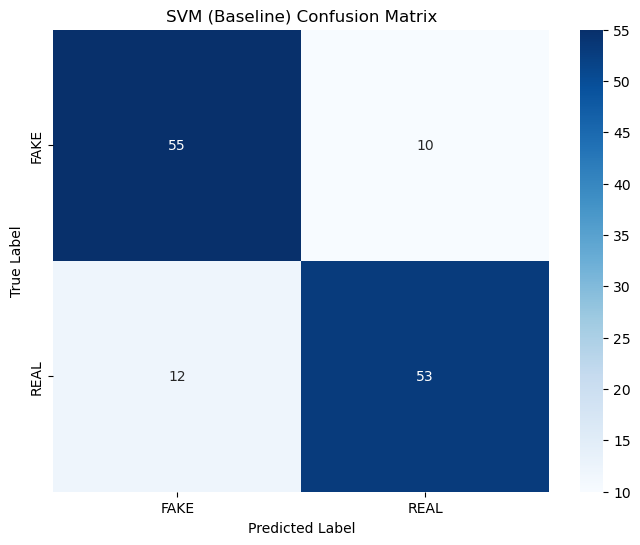

SVM (Baseline) Evaluation Completed. Check 'model_training.log' for details.


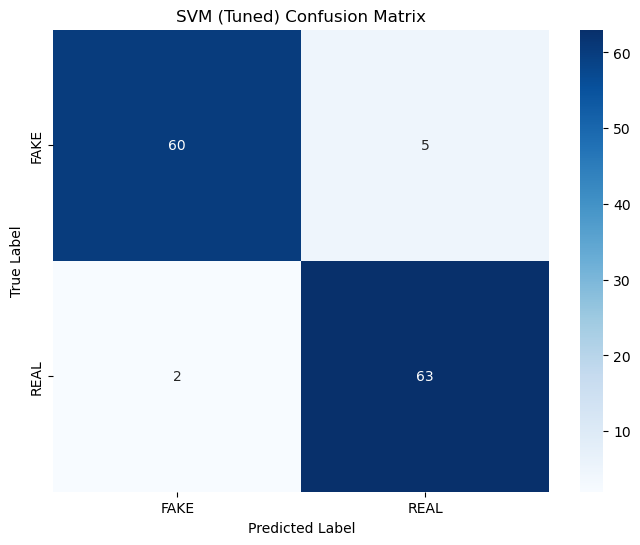

SVM (Tuned) Evaluation Completed. Check 'model_training.log' for details.


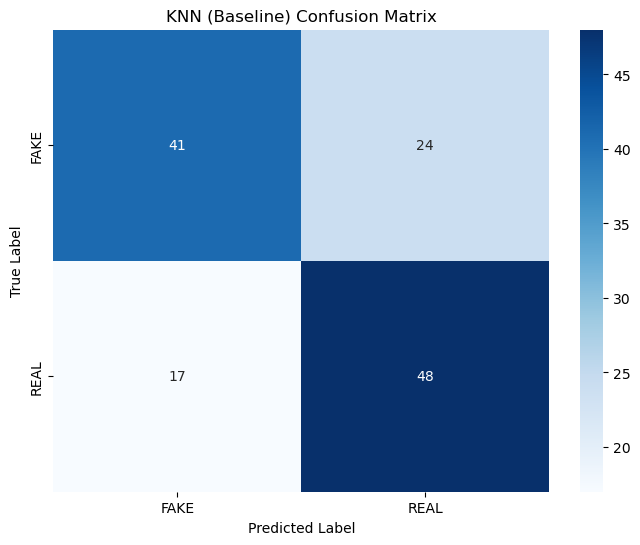

KNN (Baseline) Evaluation Completed. Check 'model_training.log' for details.


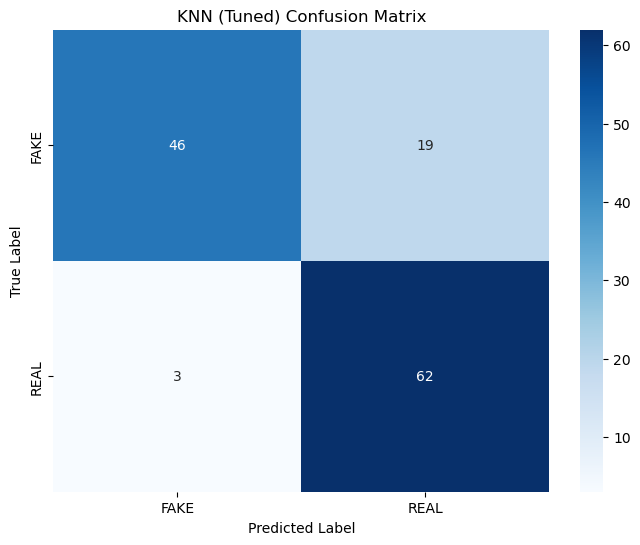

KNN (Tuned) Evaluation Completed. Check 'model_training.log' for details.


In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from collections import Counter
from imblearn.over_sampling import SMOTE
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(message)s'
)

def load_features_and_labels(base_folder):
    """
    Load features and corresponding labels from the dataset.
    Combines REAL and BALANCED_REAL to handle class imbalance.
    """
    X = []
    y = []
    label_map = {"FAKE": 0, "REAL": 1, "BALANCED_REAL": 1}  # Map class labels to integers

    for category_folder in os.listdir(base_folder):
        category_path = os.path.join(base_folder, category_folder)
        if not os.path.isdir(category_path):
            continue

        label = label_map.get(category_folder)
        if label is None:
            continue

        logging.info(f"Processing folder: {category_folder} (Label: {label})")

        for video_folder in os.listdir(category_path):
            video_folder_path = os.path.join(category_path, video_folder)
            if not os.path.isdir(video_folder_path):
                continue

            features_path = os.path.join(video_folder_path, "features.npy")
            if os.path.exists(features_path):
                try:
                    features = np.load(features_path)
                    if features.ndim == 1:  # Ensure features are 2D
                        features = features.reshape(1, -1)
                    X.append(features.flatten())  # Flatten feature array
                    y.append(label)
                except Exception as e:
                    logging.error(f"Error loading features from {features_path}: {e}")
            else:
                logging.warning(f"Features file not found: {features_path}")

    logging.info(f"Loaded {len(X)} feature sets.")
    logging.info("Initial Class Distribution: " + str(Counter(y)))
    return np.array(X), np.array(y)

def plot_confusion_matrix(cm, labels, title):
    """
    Plot a confusion matrix.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model_with_graphs(model, X_test, y_test, model_name="Model"):
    """
    Evaluate the model and plot confusion matrix.
    """
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=["FAKE", "REAL"])
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    logging.info(f"{model_name} Classification Report:\n{report}")
    logging.info(f"{model_name} Accuracy: {acc:.4f}")
    logging.info(f"{model_name} Confusion Matrix:\n{cm}")

    # Display confusion matrix
    plot_confusion_matrix(cm, ["FAKE", "REAL"], title=f"{model_name} Confusion Matrix")

    print(f"{model_name} Evaluation Completed. Check 'model_training.log' for details.")

def train_and_plot(model, X_train, y_train, X_test, y_test, param_grid, model_name):
    """
    Train a model with and without hyperparameter tuning, and plot results.
    """
    # Baseline model
    logging.info(f"Training baseline {model_name} without hyperparameter tuning.")
    baseline_model = model
    baseline_model.fit(X_train, y_train)
    evaluate_model_with_graphs(baseline_model, X_test, y_test, model_name=f"{model_name} (Baseline)")

    # Hyperparameter tuning
    logging.info(f"Starting {model_name} training with hyperparameter tuning.")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    logging.info(f"Best Parameters for {model_name}: {grid_search.best_params_}")

    # Save the tuned model
    joblib.dump(best_model, f"{model_name.lower()}_model_optimized.pkl")
    logging.info(f"{model_name} model saved as '{model_name.lower()}_model_optimized.pkl'.")

    # Evaluate tuned model
    evaluate_model_with_graphs(best_model, X_test, y_test, model_name=f"{model_name} (Tuned)")

def main():
    logging.info("Starting the training pipeline.")

    base_folder = "output_frames_balanced"
    if not os.path.exists(base_folder):
        logging.critical(f"Base folder not found: {base_folder}. Exiting training.")
        print(f"Base folder not found: {base_folder}")
        exit()

    # Load features and labels
    X, y = load_features_and_labels(base_folder)

    if len(X) == 0:
        logging.critical("No data loaded. Exiting training.")
        print("Error: No data loaded. Exiting training.")
        exit()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    logging.info("Dataset split into training and testing sets.")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Save scaler
    joblib.dump(scaler, "scaler.pkl")
    logging.info("Feature scaler saved as 'scaler.pkl'.")

    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Save PCA
    joblib.dump(pca, "pca_transformer.pkl")
    logging.info("PCA transformer saved as 'pca_transformer.pkl'.")

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

    logging.info(f"After SMOTE, training class distribution: {Counter(y_train_resampled)}.")

    # SVM Hyperparameters
    svm_param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced', None]
    }
    train_and_plot(SVC(probability=True), X_train_resampled, y_train_resampled, X_test_pca, y_test, svm_param_grid, "SVM")

    # KNN Hyperparameters
    knn_param_grid = {
        'n_neighbors': [3, 5, 7],
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance']
    }
    train_and_plot(KNeighborsClassifier(), X_train_resampled, y_train_resampled, X_test_pca, y_test, knn_param_grid, "KNN")

    logging.info("Training pipeline completed successfully.")

if __name__ == "__main__":
    main()


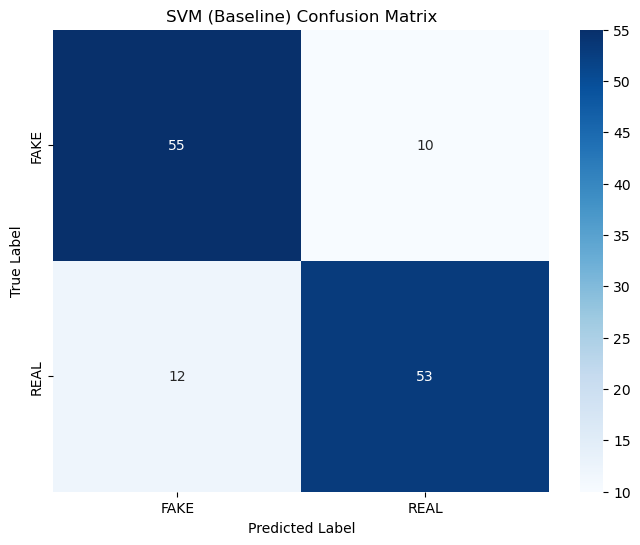

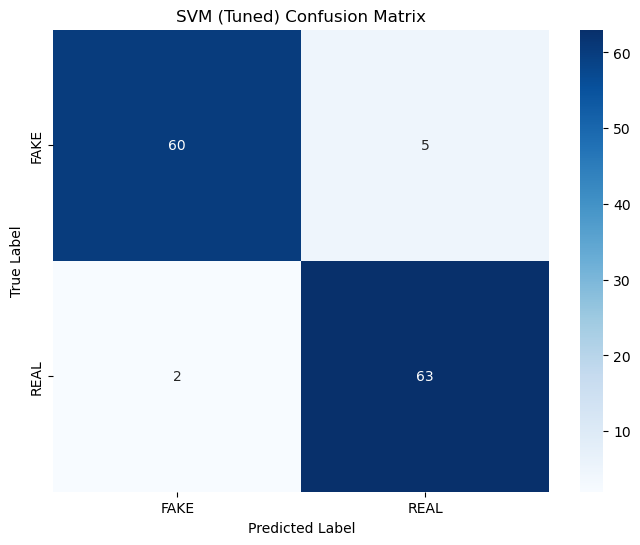

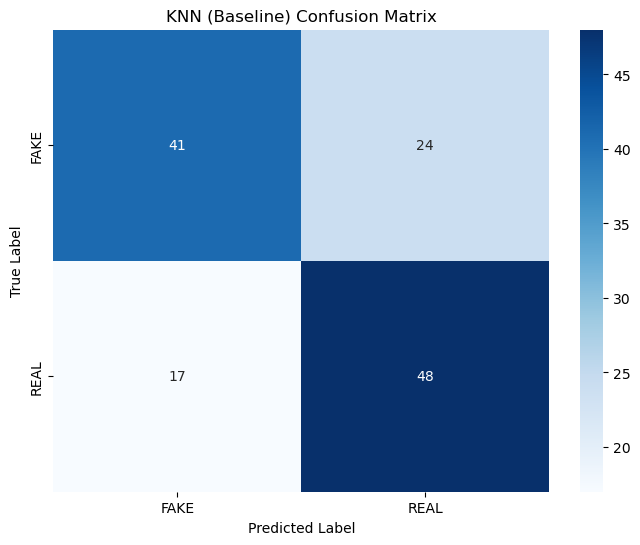

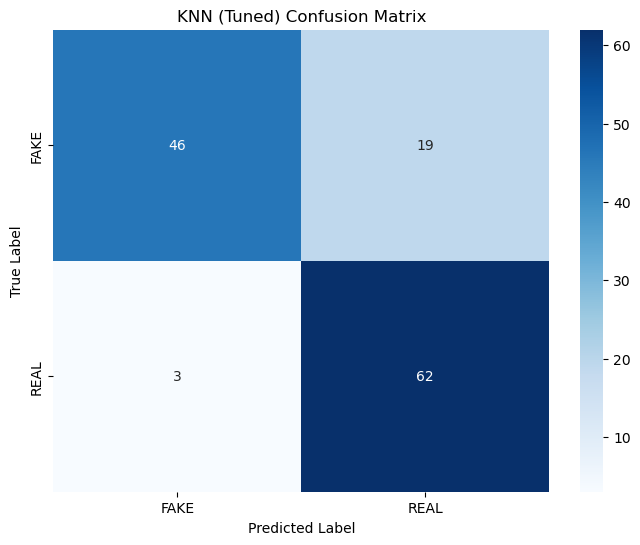

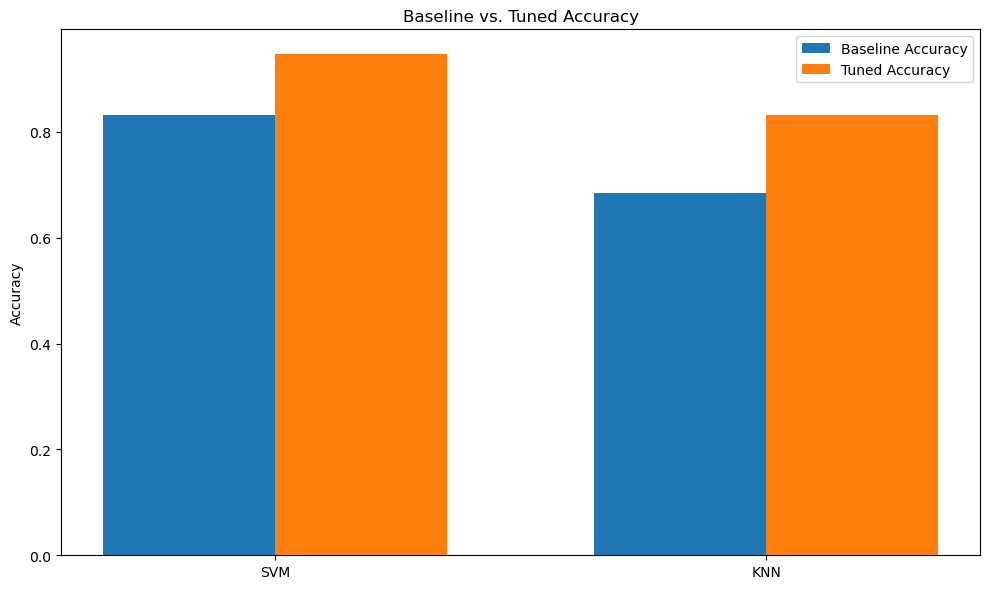

In [6]:
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from collections import Counter
from imblearn.over_sampling import SMOTE
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(message)s'
)

def load_features_and_labels(base_folder):
    """
    Load features and corresponding labels from the dataset.
    Combines REAL and BALANCED_REAL to handle class imbalance.
    """
    X = []
    y = []
    label_map = {"FAKE": 0, "REAL": 1, "BALANCED_REAL": 1}  # Map class labels to integers

    for category_folder in os.listdir(base_folder):
        category_path = os.path.join(base_folder, category_folder)
        if not os.path.isdir(category_path):
            continue

        label = label_map.get(category_folder)
        if label is None:
            continue

        logging.info(f"Processing folder: {category_folder} (Label: {label})")

        for video_folder in os.listdir(category_path):
            video_folder_path = os.path.join(category_path, video_folder)
            if not os.path.isdir(video_folder_path):
                continue

            features_path = os.path.join(video_folder_path, "features.npy")
            if os.path.exists(features_path):
                try:
                    features = np.load(features_path)
                    if features.ndim == 1:  # Ensure features are 2D
                        features = features.reshape(1, -1)
                    X.append(features.flatten())  # Flatten feature array
                    y.append(label)
                except Exception as e:
                    logging.error(f"Error loading features from {features_path}: {e}")
            else:
                logging.warning(f"Features file not found: {features_path}")

    logging.info(f"Loaded {len(X)} feature sets.")
    logging.info("Initial Class Distribution: " + str(Counter(y)))
    return np.array(X), np.array(y)

def plot_confusion_matrix(cm, labels, title):
    """
    Plot a confusion matrix.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model_with_graphs(model, X_test, y_test, model_name="Model"):
    """
    Evaluate the model and plot confusion matrix.
    """
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    logging.info(f"{model_name} Accuracy: {acc:.4f}")
    logging.info(f"{model_name} Confusion Matrix:\n{cm}")

    # Display confusion matrix
    plot_confusion_matrix(cm, ["FAKE", "REAL"], title=f"{model_name} Confusion Matrix")
    return acc

def train_and_plot(model, X_train, y_train, X_test, y_test, param_grid, model_name, accuracies):
    """
    Train a model with and without hyperparameter tuning, and plot results.
    """
    # Baseline model
    logging.info(f"Training baseline {model_name} without hyperparameter tuning.")
    baseline_model = model
    baseline_model.fit(X_train, y_train)
    baseline_acc = evaluate_model_with_graphs(baseline_model, X_test, y_test, model_name=f"{model_name} (Baseline)")
    accuracies[model_name] = {"Baseline": baseline_acc}

    # Hyperparameter tuning
    logging.info(f"Starting {model_name} training with hyperparameter tuning.")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    logging.info(f"Best Parameters for {model_name}: {grid_search.best_params_}")

    # Save the tuned model
    joblib.dump(best_model, f"{model_name.lower()}_model_optimized.pkl")
    logging.info(f"{model_name} model saved as '{model_name.lower()}_model_optimized.pkl'.")

    # Evaluate tuned model
    tuned_acc = evaluate_model_with_graphs(best_model, X_test, y_test, model_name=f"{model_name} (Tuned)")
    accuracies[model_name]["Tuned"] = tuned_acc

def plot_accuracies(accuracies):
    """
    Plot a bar graph comparing baseline and tuned accuracies for each model.
    """
    models = accuracies.keys()
    baseline_acc = [accuracies[model]["Baseline"] for model in models]
    tuned_acc = [accuracies[model]["Tuned"] for model in models]

    x = np.arange(len(models))  # the label locations
    width = 0.35  # the width of the bars

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, baseline_acc, width, label='Baseline Accuracy')
    plt.bar(x + width/2, tuned_acc, width, label='Tuned Accuracy')

    plt.ylabel('Accuracy')
    plt.title('Baseline vs. Tuned Accuracy')
    plt.xticks(x, models)
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    logging.info("Starting the training pipeline.")

    base_folder = "output_frames_balanced"
    if not os.path.exists(base_folder):
        logging.critical(f"Base folder not found: {base_folder}. Exiting training.")
        print(f"Base folder not found: {base_folder}")
        exit()

    # Load features and labels
    X, y = load_features_and_labels(base_folder)

    if len(X) == 0:
        logging.critical("No data loaded. Exiting training.")
        print("Error: No data loaded. Exiting training.")
        exit()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    logging.info("Dataset split into training and testing sets.")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Save scaler
    joblib.dump(scaler, "scaler.pkl")
    logging.info("Feature scaler saved as 'scaler.pkl'.")

    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Save PCA
    joblib.dump(pca, "pca_transformer.pkl")
    logging.info("PCA transformer saved as 'pca_transformer.pkl'.")

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

    logging.info(f"After SMOTE, training class distribution: {Counter(y_train_resampled)}.")

    accuracies = {}

    # SVM Hyperparameters
    svm_param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced', None]
    }
    train_and_plot(SVC(probability=True), X_train_resampled, y_train_resampled, X_test_pca, y_test, svm_param_grid, "SVM", accuracies)

    # KNN Hyperparameters
    knn_param_grid = {
        'n_neighbors': [3, 5, 7],
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance']
    }
    train_and_plot(KNeighborsClassifier(), X_train_resampled, y_train_resampled, X_test_pca, y_test, knn_param_grid, "KNN", accuracies)

    # Plot accuracy comparison
    plot_accuracies(accuracies)

    logging.info("Training pipeline completed successfully.")

if __name__ == "__main__":
    main()


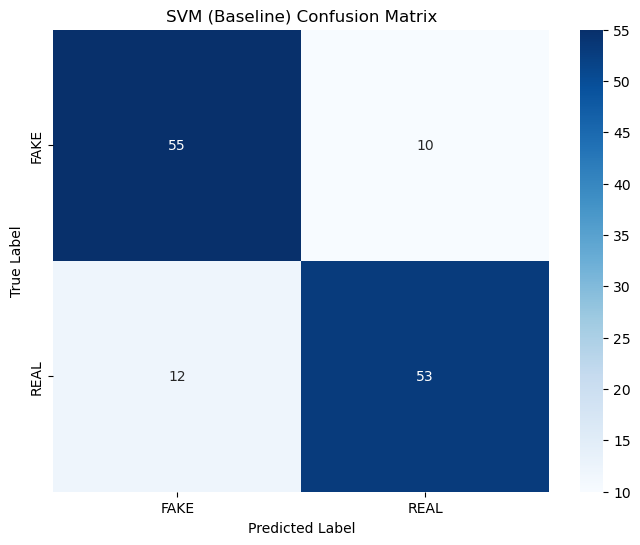

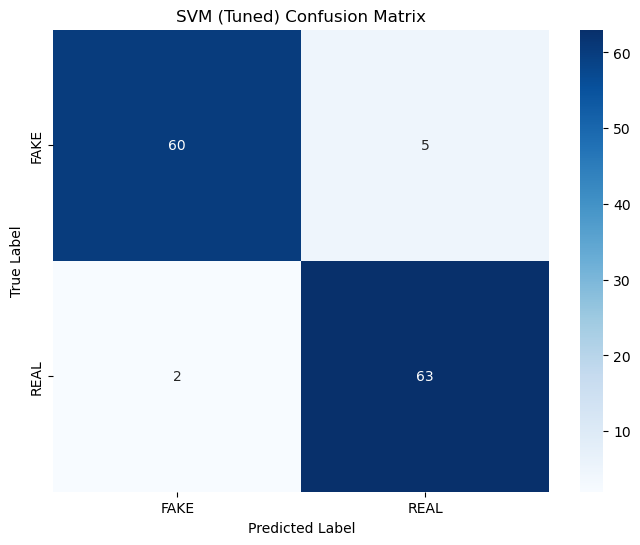

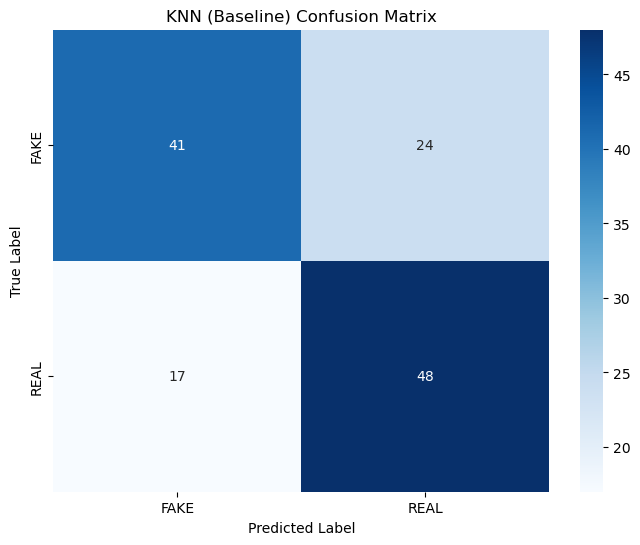

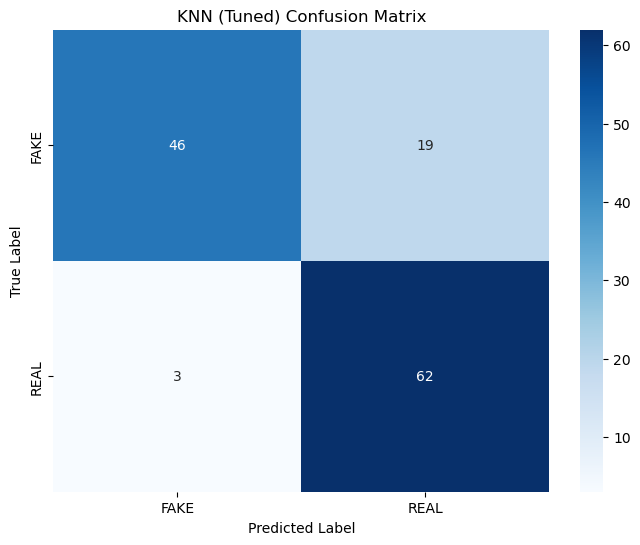

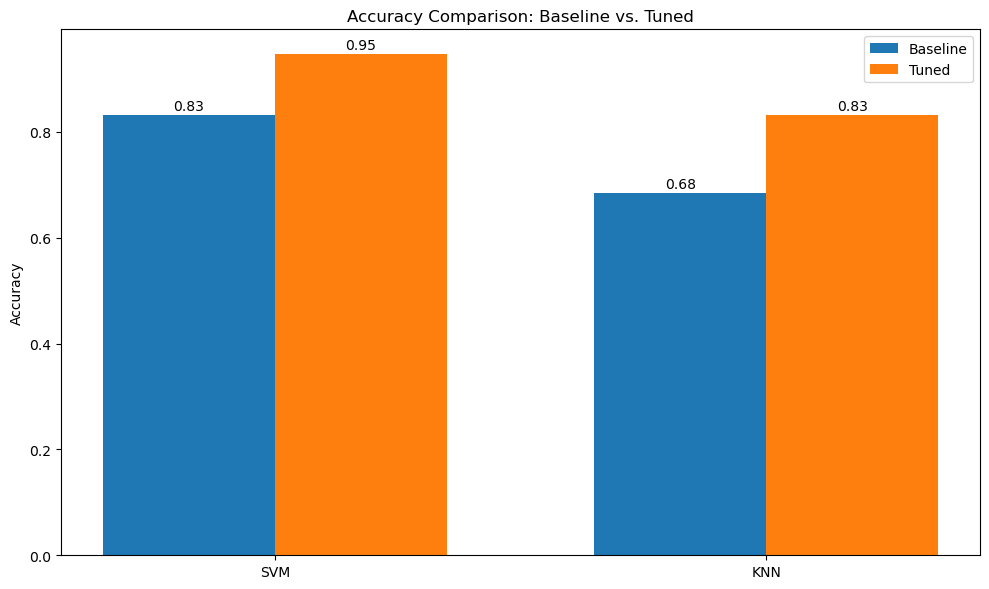

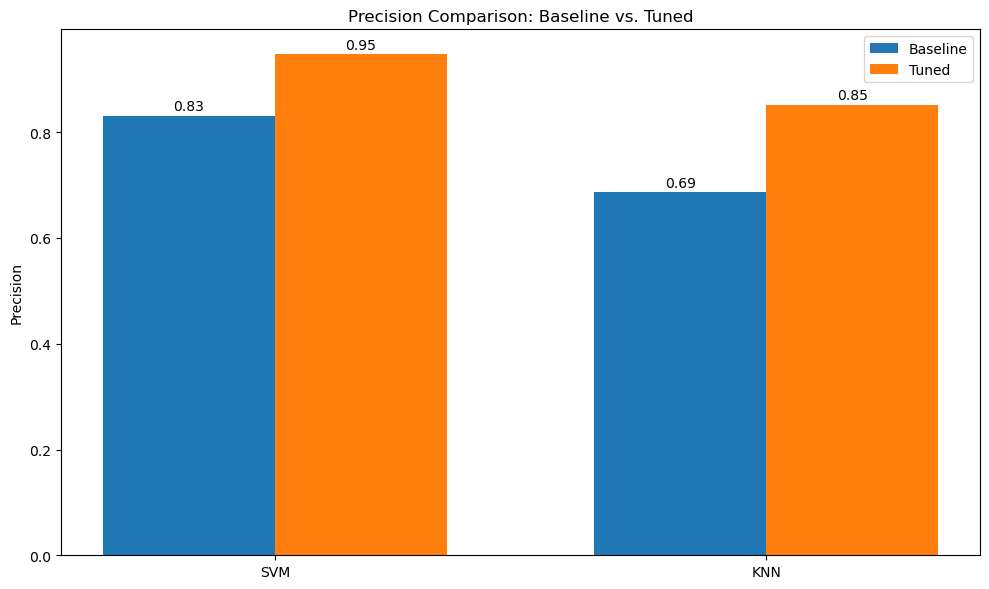

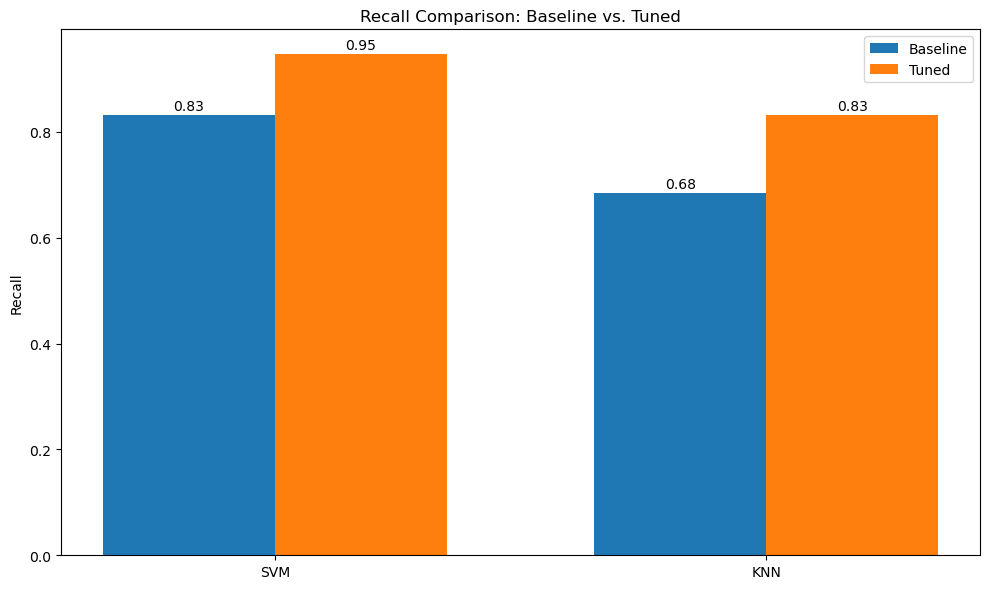

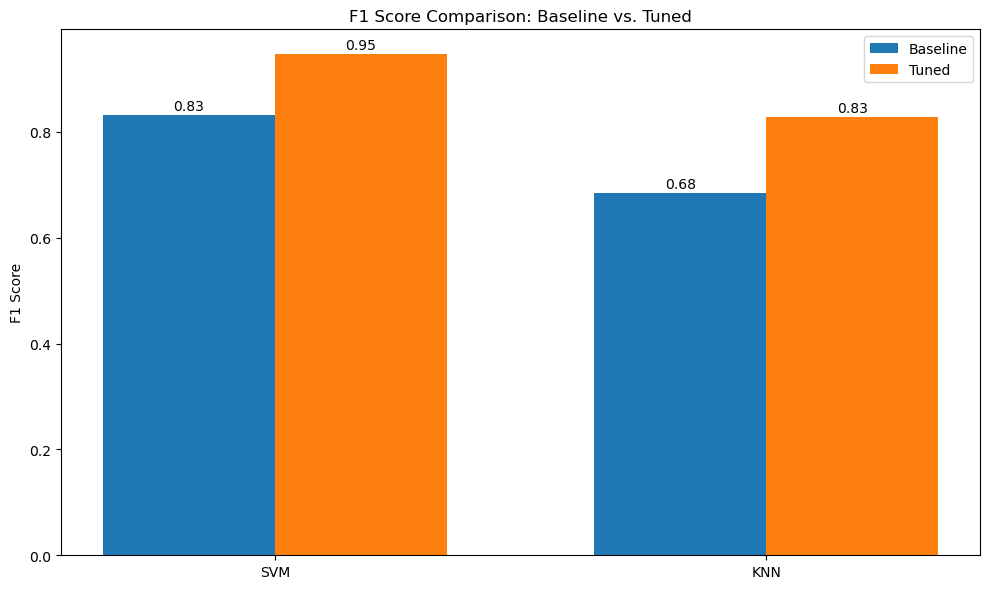

In [7]:
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from collections import Counter
from imblearn.over_sampling import SMOTE
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(message)s'
)

def load_features_and_labels(base_folder):
    """
    Load features and corresponding labels from the dataset.
    Combines REAL and BALANCED_REAL to handle class imbalance.
    """
    X = []
    y = []
    label_map = {"FAKE": 0, "REAL": 1, "BALANCED_REAL": 1}  # Map class labels to integers

    for category_folder in os.listdir(base_folder):
        category_path = os.path.join(base_folder, category_folder)
        if not os.path.isdir(category_path):
            continue

        label = label_map.get(category_folder)
        if label is None:
            continue

        logging.info(f"Processing folder: {category_folder} (Label: {label})")

        for video_folder in os.listdir(category_path):
            video_folder_path = os.path.join(category_path, video_folder)
            if not os.path.isdir(video_folder_path):
                continue

            features_path = os.path.join(video_folder_path, "features.npy")
            if os.path.exists(features_path):
                try:
                    features = np.load(features_path)
                    if features.ndim == 1:  # Ensure features are 2D
                        features = features.reshape(1, -1)
                    X.append(features.flatten())  # Flatten feature array
                    y.append(label)
                except Exception as e:
                    logging.error(f"Error loading features from {features_path}: {e}")
            else:
                logging.warning(f"Features file not found: {features_path}")

    logging.info(f"Loaded {len(X)} feature sets.")
    logging.info("Initial Class Distribution: " + str(Counter(y)))
    return np.array(X), np.array(y)

def plot_confusion_matrix(cm, labels, title):
    """
    Plot a confusion matrix.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_model_with_metrics(model, X_test, y_test, model_name="Model"):
    """
    Evaluate the model and return metrics for Accuracy, Precision, Recall, and F1-score.
    """
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    cm = confusion_matrix(y_test, y_pred)

    logging.info(f"{model_name} Accuracy: {acc:.4f}")
    logging.info(f"{model_name} Precision: {precision:.4f}")
    logging.info(f"{model_name} Recall: {recall:.4f}")
    logging.info(f"{model_name} F1 Score: {f1:.4f}")
    logging.info(f"{model_name} Confusion Matrix:\n{cm}")

    # Display confusion matrix
    plot_confusion_matrix(cm, ["FAKE", "REAL"], title=f"{model_name} Confusion Matrix")
    return acc, precision, recall, f1

def train_and_plot(model, X_train, y_train, X_test, y_test, param_grid, model_name, metrics):
    """
    Train a model with and without hyperparameter tuning, and collect metrics.
    """
    # Baseline model
    logging.info(f"Training baseline {model_name} without hyperparameter tuning.")
    baseline_model = model
    baseline_model.fit(X_train, y_train)
    baseline_metrics = evaluate_model_with_metrics(baseline_model, X_test, y_test, model_name=f"{model_name} (Baseline)")
    metrics[model_name] = {"Baseline": baseline_metrics}

    # Hyperparameter tuning
    logging.info(f"Starting {model_name} training with hyperparameter tuning.")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    logging.info(f"Best Parameters for {model_name}: {grid_search.best_params_}")

    # Save the tuned model
    joblib.dump(best_model, f"{model_name.lower()}_model_optimized.pkl")
    logging.info(f"{model_name} model saved as '{model_name.lower()}_model_optimized.pkl'.")

    # Evaluate tuned model
    tuned_metrics = evaluate_model_with_metrics(best_model, X_test, y_test, model_name=f"{model_name} (Tuned)")
    metrics[model_name]["Tuned"] = tuned_metrics

def plot_metrics(metrics):
    """
    Plot a bar graph comparing baseline and tuned metrics (Accuracy, Precision, Recall, F1).
    """
    models = metrics.keys()
    categories = ["Accuracy", "Precision", "Recall", "F1 Score"]

    for category_idx, category in enumerate(categories):
        plt.figure(figsize=(10, 6))
        baseline_values = [metrics[model]["Baseline"][category_idx] for model in models]
        tuned_values = [metrics[model]["Tuned"][category_idx] for model in models]

        x = np.arange(len(models))  # the label locations
        width = 0.35  # the width of the bars

        plt.bar(x - width/2, baseline_values, width, label='Baseline')
        plt.bar(x + width/2, tuned_values, width, label='Tuned')

        # Add values on top of bars
        for i in range(len(models)):
            plt.text(x[i] - width/2, baseline_values[i] + 0.01, f"{baseline_values[i]:.2f}", ha='center')
            plt.text(x[i] + width/2, tuned_values[i] + 0.01, f"{tuned_values[i]:.2f}", ha='center')

        plt.ylabel(category)
        plt.title(f'{category} Comparison: Baseline vs. Tuned')
        plt.xticks(x, models)
        plt.legend()
        plt.tight_layout()
        plt.show()

def main():
    logging.info("Starting the training pipeline.")

    base_folder = "output_frames_balanced"
    if not os.path.exists(base_folder):
        logging.critical(f"Base folder not found: {base_folder}. Exiting training.")
        print(f"Base folder not found: {base_folder}")
        exit()

    # Load features and labels
    X, y = load_features_and_labels(base_folder)

    if len(X) == 0:
        logging.critical("No data loaded. Exiting training.")
        print("Error: No data loaded. Exiting training.")
        exit()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    logging.info("Dataset split into training and testing sets.")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Save scaler
    joblib.dump(scaler, "scaler.pkl")
    logging.info("Feature scaler saved as 'scaler.pkl'.")

    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Save PCA
    joblib.dump(pca, "pca_transformer.pkl")
    logging.info("PCA transformer saved as 'pca_transformer.pkl'.")

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

    logging.info(f"After SMOTE, training class distribution: {Counter(y_train_resampled)}.")

    metrics = {}

    # SVM Hyperparameters
    svm_param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced', None]
    }
    train_and_plot(SVC(probability=True), X_train_resampled, y_train_resampled, X_test_pca, y_test, svm_param_grid, "SVM", metrics)

    # KNN Hyperparameters
    knn_param_grid = {
        'n_neighbors': [3, 5, 7],
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance']
    }
    train_and_plot(KNeighborsClassifier(), X_train_resampled, y_train_resampled, X_test_pca, y_test, knn_param_grid, "KNN", metrics)

    # Plot metrics comparison
    plot_metrics(metrics)

    logging.info("Training pipeline completed successfully.")

if __name__ == "__main__":
    main()


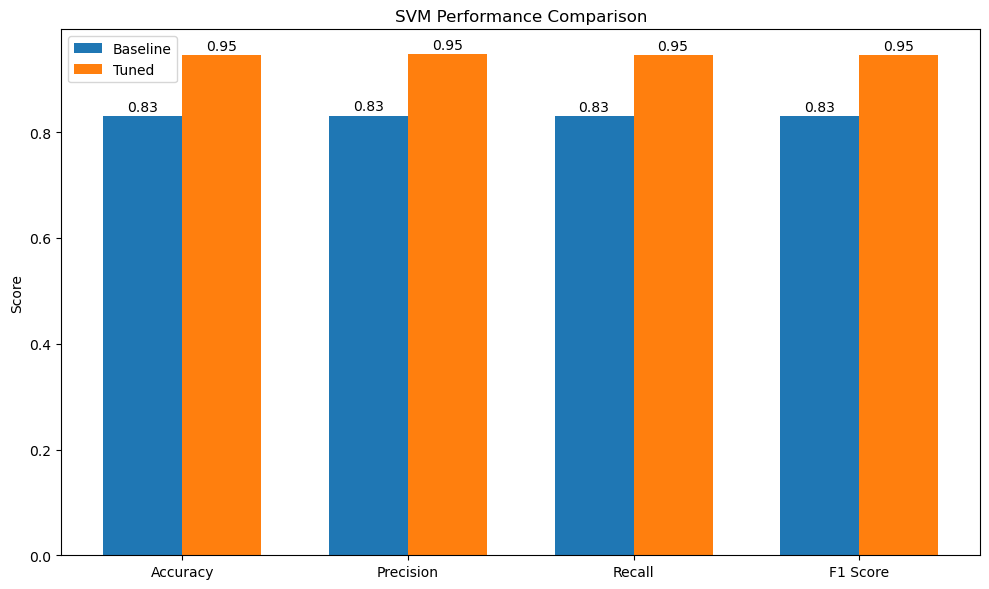

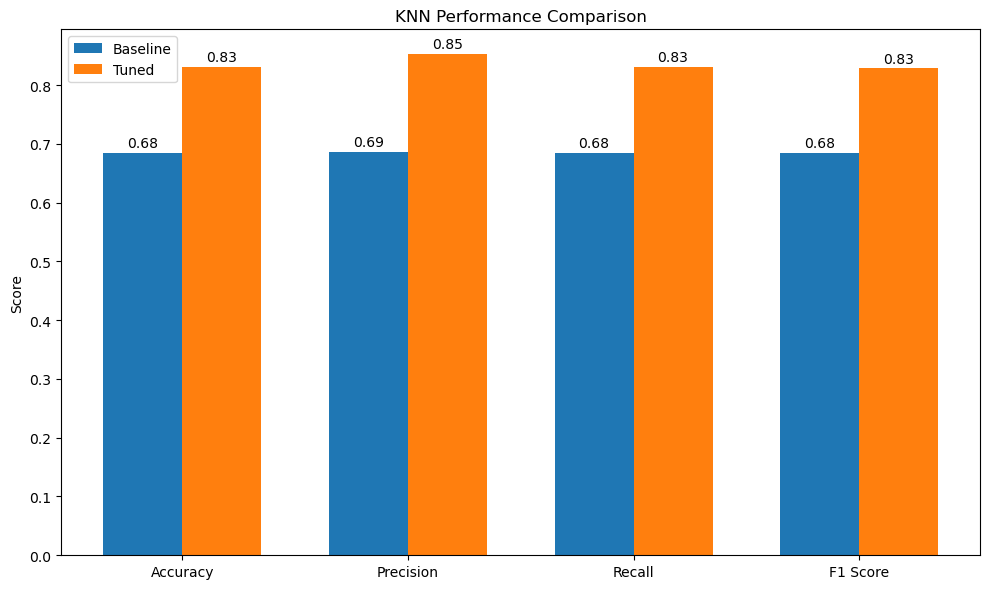

In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from collections import Counter
from imblearn.over_sampling import SMOTE
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s %(levelname)s:%(message)s'
)

def load_features_and_labels(base_folder):
    """
    Load features and corresponding labels from the dataset.
    """
    X = []
    y = []
    label_map = {"FAKE": 0, "REAL": 1, "BALANCED_REAL": 1}

    for category_folder in os.listdir(base_folder):
        category_path = os.path.join(base_folder, category_folder)
        if not os.path.isdir(category_path):
            continue

        label = label_map.get(category_folder)
        if label is None:
            continue

        for video_folder in os.listdir(category_path):
            video_folder_path = os.path.join(category_path, video_folder)
            if not os.path.isdir(video_folder_path):
                continue

            features_path = os.path.join(video_folder_path, "features.npy")
            if os.path.exists(features_path):
                try:
                    features = np.load(features_path)
                    if features.ndim == 1:
                        features = features.reshape(1, -1)
                    X.append(features.flatten())
                    y.append(label)
                except Exception as e:
                    logging.error(f"Error loading features from {features_path}: {e}")

    return np.array(X), np.array(y)

def evaluate_model_with_metrics(model, X_test, y_test):
    """
    Evaluate the model and return Accuracy, Precision, Recall, and F1 Score.
    """
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    return acc, precision, recall, f1

def train_and_collect_metrics(model, X_train, y_train, X_test, y_test, param_grid, metrics, model_name):
    """
    Train baseline and hyperparameter-tuned models and collect metrics.
    """
    # Baseline model
    baseline_model = model
    baseline_model.fit(X_train, y_train)
    metrics[model_name]["Baseline"] = evaluate_model_with_metrics(baseline_model, X_test, y_test)

    # Hyperparameter-tuned model
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    metrics[model_name]["Tuned"] = evaluate_model_with_metrics(best_model, X_test, y_test)

def plot_comparison(metrics):
    """
    Plot grouped bar charts comparing baseline and tuned metrics.
    """
    categories = ["Accuracy", "Precision", "Recall", "F1 Score"]
    models = metrics.keys()

    for model in models:
        plt.figure(figsize=(10, 6))
        baseline_values = [metrics[model]["Baseline"][i] for i in range(len(categories))]
        tuned_values = [metrics[model]["Tuned"][i] for i in range(len(categories))]
        x = np.arange(len(categories))  # Label locations
        width = 0.35  # Bar width

        # Plot bars
        plt.bar(x - width / 2, baseline_values, width, label="Baseline")
        plt.bar(x + width / 2, tuned_values, width, label="Tuned")

        # Add values on top of bars
        for i in range(len(categories)):
            plt.text(x[i] - width / 2, baseline_values[i] + 0.01, f"{baseline_values[i]:.2f}", ha='center')
            plt.text(x[i] + width / 2, tuned_values[i] + 0.01, f"{tuned_values[i]:.2f}", ha='center')

        # Labeling
        plt.ylabel("Score")
        plt.title(f"{model} Performance Comparison")
        plt.xticks(x, categories)
        plt.legend()
        plt.tight_layout()
        plt.show()

def main():
    base_folder = "output_frames_balanced"
    if not os.path.exists(base_folder):
        print(f"Base folder not found: {base_folder}")
        return

    # Load features and labels
    X, y = load_features_and_labels(base_folder)

    if len(X) == 0:
        print("No data found. Ensure dataset is correctly structured.")
        return

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # Preprocessing
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

    # Metrics storage
    metrics = {"SVM": {"Baseline": None, "Tuned": None}, "KNN": {"Baseline": None, "Tuned": None}}

    # SVM
    svm_param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'class_weight': ['balanced', None]
    }
    train_and_collect_metrics(SVC(probability=True), X_train_resampled, y_train_resampled, X_test_pca, y_test, svm_param_grid, metrics, "SVM")

    # KNN
    knn_param_grid = {
        'n_neighbors': [3, 5, 7],
        'metric': ['euclidean', 'manhattan'],
        'weights': ['uniform', 'distance']
    }
    train_and_collect_metrics(KNeighborsClassifier(), X_train_resampled, y_train_resampled, X_test_pca, y_test, knn_param_grid, metrics, "KNN")

    # Plot metrics comparison
    plot_comparison(metrics)

if __name__ == "__main__":
    main()
